In [89]:
import json
import re
import sys
import pandas as pd
import numpy as np


In [90]:
df_train = pd.read_csv('../storage/train_data/train-250317-01.csv', encoding='cp949')
df_train.head()

,공고번호,주택명,공급지역코드,공급지역명,공급위치우편번호,공급위치,공급규모,모집공고일,청약접수시작일,청약접수종료일,...,위도,경도,행정동코드,법정동코드,시도,시군구,읍면동1,읍면동2,전용면적당 공급금액(최고가기준),전용면적당 시세차익
0,2025000043,부천 JY 포에시아,410,경기,14636,경기도 부천시 원미구 신흥로 20,55,2025-02-28,2025-03-10,2025-03-11,...,37.485377,126.776922,4.119252e+09,4.119210e+09,경기,부천시 원미구,심곡2동,심곡동,8.767442e+06,NaN
1,2025000043,부천 JY 포에시아,410,경기,14636,경기도 부천시 원미구 신흥로 20,55,2025-02-28,2025-03-10,2025-03-11,...,37.485377,126.776922,4.119252e+09,4.119210e+09,경기,부천시 원미구,심곡2동,심곡동,8.767442e+06,NaN
2,2025000043,부천 JY 포에시아,410,경기,14636,경기도 부천시 원미구 신흥로 20,55,2025-02-28,2025-03-10,2025-03-11,...,37.485377,126.776922,4.119252e+09,4.119210e+09,경기,부천시 원미구,심곡2동,심곡동,8.767442e+06,NaN
3,2025000043,부천 JY 포에시아,410,경기,14636,경기도 부천시 원미구 신흥로 20,55,2025-02-28,2025-03-10,2025-03-11,...,37.485377,126.776922,4.119252e+09,4.119210e+09,경기,부천시 원미구,심곡2동,심곡동,8.767442e+06,NaN
4,2025000043,부천 JY 포에시아,410,경기,14636,경기도 부천시 원미구 신흥로 20,55,2025-02-28,2025-03-10,2025-03-11,...,37.485377,126.776922,4.119252e+09,4.119210e+09,경기,부천시 원미구,심곡2동,심곡동,8.767442e+06,NaN


In [80]:
df_train['모집공고일_년월'] = pd.to_datetime(df_train['모집공고일']).dt.strftime('%Y%m').astype(int)
df_train['모집공고일_년월']

0        202502
1        202502
2        202502
3        202502
4        202502
          ...  
17245    202003
17246    202003
17247    202003
17248    202003
17249    202003
Name: 모집공고일_년월, Length: 17250, dtype: int64

In [81]:
df_train['전용면적당 공급금액(최고가기준)'] = df_train['공급금액(최고가 기준)'] / df_train['전용면적']
df_train['전용면적당 공급금액(최고가기준)']

0        8.767442e+06
1        8.767442e+06
2        8.767442e+06
3        8.767442e+06
4        8.767442e+06
             ...     
17245    5.085714e+06
17246    5.085714e+06
17247    5.085714e+06
17248    5.085714e+06
17249    5.085714e+06
Name: 전용면적당 공급금액(최고가기준), Length: 17250, dtype: float64

In [82]:
df_real_estate_price = pd.read_csv('서울경기인천_전체_월별_법정동별_실거래가_평균.csv', encoding='cp949')
df_real_estate_price

,년월,구,법정동,법정동시군구코드,법정동읍면동코드,거래금액(만원),전용면적당 거래금액(만원),법정동코드
0,202501,강남구,개포동,11680,10300,237042.451613,3379.567200,1168010300
1,202501,강남구,논현동,11680,10800,159525.000000,1940.551981,1168010800
2,202501,강남구,대치동,11680,10600,357196.153846,3286.645631,1168010600
3,202501,강남구,도곡동,11680,11800,261500.000000,2646.709886,1168011800
4,202501,강남구,삼성동,11680,10500,266062.500000,2930.899752,1168010500
...,...,...,...,...,...,...,...,...
50247,202012,중구,운서동,28110,14700,25065.789474,320.857355,2811014700
50248,202012,중구,인현동,28110,13600,12500.000000,208.333333,2811013600
50249,202012,중구,전동,28110,13700,17400.000000,347.406651,2811013700
50250,202012,중구,중산동,28110,14500,34948.728814,471.968366,2811014500


In [83]:
def apply_price_diff(row):
    b_code = row['법정동코드']
    date = row['모집공고일_년월']
    offer_price = row['전용면적당 공급금액(최고가기준)']

    mask = (df_real_estate_price['법정동코드'] == b_code) & (df_real_estate_price['년월'] == date)
    matched_rows = df_real_estate_price[mask]

    if matched_rows.empty:
        # 매칭된 데이터가 없을 때 기본값 처리 (예: NaN)
        return np.nan

    real_price = matched_rows.iloc[0]['전용면적당 거래금액(만원)']
    price_diff = offer_price - real_price

    return price_diff

df_train['전용면적당 시세차익'] = df_train.apply(apply_price_diff, axis=1)

In [84]:
df_train.drop(columns='모집공고일_년월', inplace=True)

In [ ]:
df_train.to_csv('청약_매물_시세차익_데이터.csv', index=False, encoding='cp949')

In [86]:
df_train = pd.read_csv('청약_매물_시세차익_데이터.csv', encoding='cp949')
df_train.head()

,공고번호,주택명,공급지역코드,공급지역명,공급위치우편번호,공급위치,공급규모,모집공고일,청약접수시작일,청약접수종료일,...,위도,경도,행정동코드,법정동코드,시도,시군구,읍면동1,읍면동2,전용면적당 공급금액(최고가기준),전용면적당 시세차익
0,2025000043,부천 JY 포에시아,410,경기,14636,경기도 부천시 원미구 신흥로 20,55,2025-02-28,2025-03-10,2025-03-11,...,37.485377,126.776922,4.119252e+09,4.119210e+09,경기,부천시 원미구,심곡2동,심곡동,8.767442e+06,NaN
1,2025000043,부천 JY 포에시아,410,경기,14636,경기도 부천시 원미구 신흥로 20,55,2025-02-28,2025-03-10,2025-03-11,...,37.485377,126.776922,4.119252e+09,4.119210e+09,경기,부천시 원미구,심곡2동,심곡동,8.767442e+06,NaN
2,2025000043,부천 JY 포에시아,410,경기,14636,경기도 부천시 원미구 신흥로 20,55,2025-02-28,2025-03-10,2025-03-11,...,37.485377,126.776922,4.119252e+09,4.119210e+09,경기,부천시 원미구,심곡2동,심곡동,8.767442e+06,NaN
3,2025000043,부천 JY 포에시아,410,경기,14636,경기도 부천시 원미구 신흥로 20,55,2025-02-28,2025-03-10,2025-03-11,...,37.485377,126.776922,4.119252e+09,4.119210e+09,경기,부천시 원미구,심곡2동,심곡동,8.767442e+06,NaN
4,2025000043,부천 JY 포에시아,410,경기,14636,경기도 부천시 원미구 신흥로 20,55,2025-02-28,2025-03-10,2025-03-11,...,37.485377,126.776922,4.119252e+09,4.119210e+09,경기,부천시 원미구,심곡2동,심곡동,8.767442e+06,NaN


<Axes: xlabel='전용면적당 시세차익', ylabel='Count'>

findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
findfont: Font family 'AppleGothic' not found.
c:\Users\user\anaconda3\envs\venv\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\user\anaconda3\envs\venv\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from font(s) D

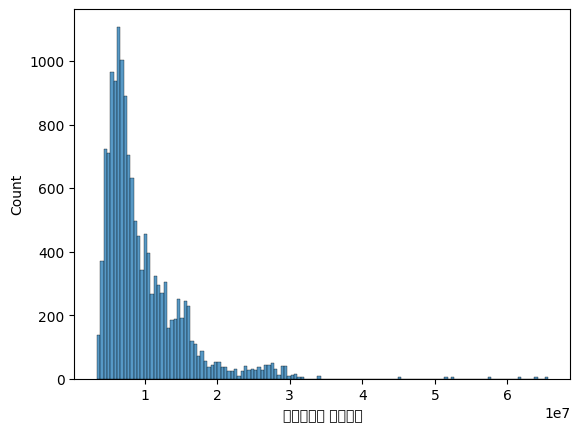

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] =False

sns.histplot(df_train, x='전용면적당 시세차익')